# How to build a machine learning marketing model for banking using Google Cloud Platform and Python

This notebook shows you how to build a marketing model for banking using [Google Cloud Platform](https://cloud.google.com/) (GCP). Many financial institutions use traditional on-premise methods and tooling to build models for marketing. This notebook takes you through the steps to build a Machine Learning model using open source and Google Cloud Platform. Some of the advantages of this approach are:

* Flexibility: The open source models can easily be ported. 
* Scalability: It's easy to scale using the power of Google Cloud.
* Transparency: Lime will give you more insights in the model.
* Ease of use: Pandas and Scikit-learn are easy to use.

We will go into some important topics for modeling within banking, like data exploration and model explanation. This notebook is created so that it can be re-used for migrating workloads to open source and the cloud. We will take you through the following steps:

* Fetching data from [Google BigQuery](https://cloud.google.com/bigquery/)
*   Data Exploration using [Pandas profling](https://github.com/pandas-profiling/pandas-profiling)
*   Data partitioning using [Scikit-learn](http://scikit-learn.org/)
*   Data Engineering
*   Building and evaluating different models
*   Explaining the models using [Lime](https://github.com/marcotcr/lime)
*   Use [Cloud AI Platform](https://cloud.google.com/ml-engine/) to deploy to model as an API
*   Get predictions


#### Type of model

The goal of this model is to predict if the banking client will subscribe a term deposit, which is variable `y` in our dataset. This class of models are called "propensity to buy" models and this type of problem is binary classification. "Propensity to buy" models can help us predict the success of our marketing campaign.

<br>

#### What this notebook will not do

* Teach you the basics of Machine Learning. We focus on how to train and deploy a ML model using the power of Google Cloud. 
* There is not one Cloud solution for all of your business problems. Because we choose Pandas and Scikit-Learn, they both have limitations. We choose to use Pandas + Scikit-learn because it helps making the transition from on-prem solutions to open source and Google Cloud easier. We have other solutions that can help you scale things even further using Google Cloud. 

## Prerequisites
Before we get started we need to go through a couple of prerequisites. 

First, install two packages that your environment may not have (lime and pandas profiling). After running the cell, restart the Kernel by clicking 'Kernel > Restart Kernel' on the top menu.

In [1]:
!pip install pandas-profiling
!pip install lime

     |████████████████████████████████| 275 kB 7.6 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=cede7a0739b00d7e3625058657faf528969a3aa577edd67d45e3781a60df5471
  Stored in directory: /home/jupyter/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


*(Only if you are using a colab notebook)* We need to authenticate to Google Cloud and create the service client. After running the cell below, a link will appear which you need to click on and follow the instructions.

In [2]:
# ONLY RUN IF YOU ARE IN A COLAB NOTEBOOK.
from google.colab import auth
auth.authenticate_user()

ModuleNotFoundError: No module named 'google.colab'

Next, we need to set our project. Replace 'PROJECT_ID' with your GCP project ID.

In [3]:
%env GOOGLE_CLOUD_PROJECT=healthy-earth-309119

env: GOOGLE_CLOUD_PROJECT=healthy-earth-309119


In [4]:
!gcloud config set project $GOOGLE_CLOUD_PROJECT

Updated property [core/project].


Third, you need to activate some of the GCP services that we will be using. Run the following cell if you need to activate API's. Which can also be done via the GUI via APIs and Services -> Enable APIS and Services.

In [ ]:
!gcloud services enable ml.googleapis.com
!gcloud services enable bigquery-json.googleapis.com

The data that we will be using for this demo is the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

The first step we will need to take is to create a BigQuery dataset and a table so that we can store this data. Make sure that you replace `your_dataset` and `your_table` variables with any dataset and table name you want.

In [5]:
import os
your_dataset = 'public_data'
your_table = 'bank_marketing'
project_id = os.environ["GOOGLE_CLOUD_PROJECT"]

In [6]:
!bq mk -d {project_id}:{your_dataset}
!bq mk -t {your_dataset}.{your_table}

Dataset 'healthy-earth-309119:public_data' successfully created.
Table 'healthy-earth-309119:public_data.bank_marketing' successfully created.


There is a public dataset avaliable which has cleaned up some of the rows in the `UCI Bank Marketing Dataset`. We will download this file in the next cell and save locally as `data.csv`.

In [7]:
!curl https://storage.googleapis.com/erwinh-public-data/bankingdata/bank-full.csv --output data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4502k  100 4502k    0     0  10.9M      0 --:--:-- --:--:-- --:--:-- 10.9M


We will now upload the `data.csv` file into our BigQuery table.

In [8]:
!bq load --autodetect --source_format=CSV --field_delimiter ';' --skip_leading_rows=1 --replace {your_dataset}.{your_table} data.csv

Upload complete.
Waiting on bqjob_rac10e9c16103e15_00000178a3c5374d_1 ... (2s) Current status: DONE   


## 1) Fetching data 

In this chapter we will get data from BigQuery and create a Pandas dataframe that we will be using for data engineering, data visualization and modeling.

###  Data from BigQuery to Pandas
We are going to use the datalab.bigquery library to fetch data from bigquery and load a Pandas dataframe.

In [9]:
#import pandas and bigquery library

import pandas as pd
from google.cloud import bigquery as bq

We doing two things in this cell:


1.   We are executing an SQL query
2.   We are converting the output from BQ into a pandas dataframe using `.to_dataframe()`



In [10]:
# Execute the query and converts the result into a Dataframe

client = bq.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `%s.%s`
''' % (your_dataset, your_table)).to_dataframe()

df.head(3).T

0          1          2
age               42         56         44
job           admin.     admin.     admin.
marital       single    married    married
education  secondary  secondary  secondary
default        False      False      False
balance         -247       1270       4826
housing         True       True       True
loan            True      False      False
contact    telephone   cellular   cellular
day               21         17         17
month            oct        nov        nov
duration         519         80        102
campaign           1          2          1
pdays            166        165        185
previous           1          2          4
poutcome       other      other      other
y               True      False      False

We will now expore the data we got from BQ

## 2) Data exploration

We will use [Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) to perform data exploration. This will give us information including distributions for each feature, missing values, the maximum and minimum values and many more. These are all out of the box. Run the next cell first if you haven't installed pandas profiling. (Note if after you haved installed pandas profiling, you get an import error, restart your kernel and re-run all the cells up until this section).

In [11]:
import pandas_profiling as pp

In [12]:
# Let's create a Profile Report using the dataframe that we just created. 
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Some interesting points from the pandas profiling:
* We have categorical and boolean columns which we need to convert to numeric values
* The predictor value is very skewed (only 5289 defaulted compared to a massive 39922 users not defaulting) so we need to ensure that our training and testing splits are representative of this skew
* No missing values

## 3) Data partitioning (split data into training and testing)

As our dataset is highly skewed, we need to be very careful with our sampling approach. Two things need to be considered: 

1.   Shuffle the dataset to avoid any form of pre-ordering.
2.   Use [stratified sampling](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) (SE). SE makes sure that both datasets (test, training) do not significantly differ for variables of interest. In our case we use SE to achieve a similar distribution of `y` for both datasets.



In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

#Here we apply a shuffle and stratified split to create a train and test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
for train_index, test_index in split.split(df, df["y"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [14]:
# check the split sizes

print(strat_train_set.size)
print(strat_test_set.size)

614856
153731


In [15]:
# We can now check the data
strat_test_set.head(3).T

26627       804        17565
age                29          46         49
job        management  management   services
marital        single     married    married
education    tertiary   secondary  secondary
default         False       False      False
balance           307        1098       -507
housing          True       False      False
loan            False       False      False
contact      cellular    cellular  telephone
day                 2           8         28
month             jun         may        jan
duration          690          99        148
campaign            1           3          2
pdays              -1         343         -1
previous            0           3          0
poutcome      unknown       other    unknown
y                True       False      False

## 4) Data preparation (feature engineering)

Before we can create Machine Learning models, we need to format the data so that it is in a form that the models can understand.

We need to do the following steps:

1.   For the numeric columns, we need to normalize these columns so that one column with very large values does not bias the computation.
2.   Turn categorical values into numeric values replacing each unique value in a column with an integer. For example, if a column named "Colour" has three unique strings "red", "yellow" and "blue" they will be assigned the values 0, 1 and 2 respectively. So each instance of yellow in that column will be replaced with 0. Note: [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is an alternative method to convert categorical values to integers.
3.   For True/False values we simply convert these to 1/0 respectively.



In [16]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

Now we are going to ceate a function to split the label we want to predict and the feature that we will use to predict this value. In addition, we convert the label to 1/0.

In [17]:
def return_features_and_label(df):
    """returns features and label given argument dataframe"""
    
    # Get all the columns except "y". It's also possible to exclude other columns
    X = df.drop("y", axis=1)
    
    Y = df["y"].copy ()
    # Convert our label to an integer
    Y = LabelEncoder().fit_transform(Y) 
    return X, Y

In [18]:
train_features, train_label = return_features_and_label(strat_train_set)

Our training dataset, `train_features`, contains both categorical and numeric values. However, we know that machine learning models can only use numeric values. The function below converts categorical variables to integers and then normalizes the current numeric columns so that certain columns with very large numbers would not over-power those columns whose values are not so large.

In [20]:
def data_pipeline(df):
    """Normalizes and converts data and returns dataframe """
  
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = list(set(df.columns) - set(num_cols))
    # Normalize Numeric Data
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    # Convert categorical variables to integers
    df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    return df

In [21]:
train_features_prepared = data_pipeline(train_features)

In [22]:
train_features_prepared.head(3).T

14217     27492     18251
age       -0.271979  1.326772 -0.648155
job        8.000000  9.000000  7.000000
marital    2.000000  1.000000  2.000000
education  3.000000  1.000000  1.000000
default    0.000000  0.000000  0.000000
balance   -0.207265 -0.351958  0.876312
housing    0.000000  1.000000  1.000000
loan       0.000000  0.000000  1.000000
contact    2.000000  2.000000  0.000000
day        0.267121 -0.455160 -0.094020
month      6.000000  8.000000  8.000000
duration  -0.749039  0.878587 -0.888218
campaign  -0.568998 -0.568998 -0.568998
pdays     -0.410296 -0.410296 -0.410296
previous  -0.240959 -0.240959 -0.240959
poutcome   3.000000  3.000000  3.000000

Some columns in our training dataset may not be very good predictors. This means that we should perform feature selection to get only the best predictors and reduce our time for training since our dataset will be much smaller.

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif  

predictors = train_features_prepared.columns

# Perform feature selection where `k` (5 in this case) indicates the number of features we wish to select
selector = SelectKBest(f_classif, k=5)
selector.fit(train_features_prepared[predictors], train_label) 

SelectKBest(k=5)

To visualize the selection, we can plot a graph to look at the scores for each feature. Note that the `duration` feature had 0 as its p-value and so it could not be shown in the logarithmic scale.

In [24]:
# Get the p-values from our selector for each model and convert to a logarithmic scale for easy vizualization
importance_score = -np.log(selector.pvalues_)

# Plot each column with their importance score
plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors)), importance_score, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors)), predictors)

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


It's also possible to use a Tree classifier to select the best features. It's often a good option when you have a highly imbalanced dataset. 

In [25]:
# Example of how to use a Tree classifier to select best features. 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel    

predictors_tree = train_features_prepared.columns

selector_clf = ExtraTreesClassifier(n_estimators=50, random_state=0)
selector_clf.fit(train_features_prepared[predictors], train_label) 

ExtraTreesClassifier(n_estimators=50, random_state=0)

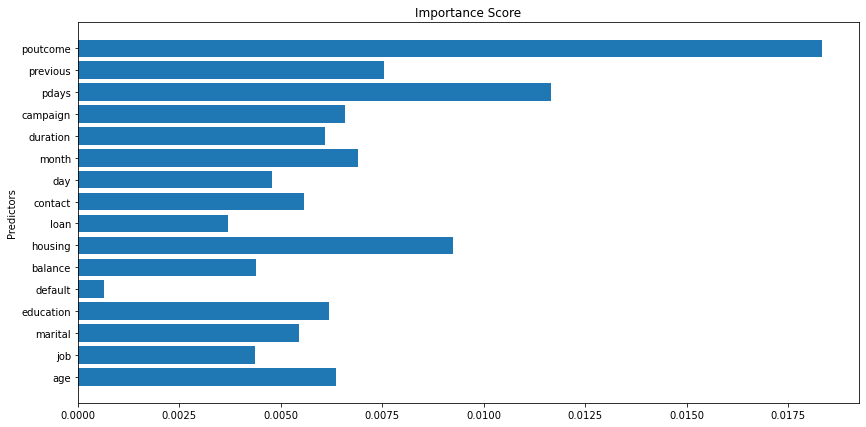

In [26]:
# Plotting feature importance

importances = selector_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector_clf.estimators_],
             axis=0)

plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors_tree)), std, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors_tree)), predictors_tree)

plt.show()

The plot sometimes may be difficult to know which are the top five features. We can display a simple table with the top selected features and their scores. We are using `SelectKBest` with `f_classif`. 

In [27]:
# Plot the top 5 features based on the Log Score that we calculated earlier.  
train_prepared_indexs = [count for count, selected in enumerate(selector.get_support()) if selected == True]

pd.DataFrame(
    {'Feature' : predictors[train_prepared_indexs],
     'Original Score': selector.pvalues_[train_prepared_indexs],
     'Log Score' : importance_score[train_prepared_indexs]
    }
)

Feature  Original Score   Log Score
0   housing   1.375125e-161  370.397656
1   contact   7.567334e-182  417.046646
2  duration    0.000000e+00         inf
3     pdays    3.376512e-90  206.015815
4  previous    1.223846e-60  137.953107

Let us now create a training dataset that contains the top 5 features.

In [28]:
# Here we are creating our new dataframe based on the selected features (from selector)
train_prepared_columns = [col for (selected, col) in zip(selector.get_support(), predictors) if selected == True]
train_prepared = train_features_prepared[train_prepared_columns]

## 5) Building and evaluation of the models

In this section we will be building models using [Scikit-Learn](http://scikit-learn.org/stable/). We show how [hyper parameter tuning / optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) and model evaluation can be used to select the best model for deployment.

In [30]:
# Importing libraries needed

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
import numpy as np

The following code defines different hyperparameter combinations. More precisely, we define different model types (e.g., Logistic Regression, Support Vectors Machines (SVC)) and the corresponding lists of parameters that will be used during the optimization process (e.g., different kernel types for SVM).

In [31]:
# this function will create the classifiers (models) that we want to test
def create_classifiers(): 
    """Create classifiers and specify hyper parameters"""
    
    log_params = [{'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}]

    knn_params = [{'n_neighbors': [3, 4, 5]}]

    svc_params = [{'kernel': ['linear', 'rbf'], 'probability': [True]}]

    tree_params = [{'criterion': ['gini', 'entropy']}]

    forest_params = {'n_estimators': [1, 5, 10]}

    mlp_params = {'activation': [
                    'identity', 'logistic', 'tanh', 'relu'
                  ]}

    ada_params = {'n_estimators': [1, 5, 10]}

    classifiers = [
        ['LogisticRegression', LogisticRegression(random_state=42),
         log_params],
        ['KNeighborsClassifier', KNeighborsClassifier(), knn_params],
        ['SVC', SVC(random_state=42), svc_params],
        ['DecisionTreeClassifier',
         DecisionTreeClassifier(random_state=42), tree_params],
        ['RandomForestClassifier',
         RandomForestClassifier(random_state=42), forest_params],
        ['MLPClassifier', MLPClassifier(random_state=42), mlp_params],
        ['AdaBoostClassifier', AdaBoostClassifier(random_state=42),
         ada_params],
        ]

    return classifiers


After defining our hyperparameters, we use sklearn's [grid search](http://scikit-learn.org/stable/modules/grid_search.html) to iterate through the different combinations of hyperparameters and return the best parameters for each model type. Furthermore, we use [crossvalidation](http://scikit-learn.org/stable/modules/cross_validation.html), pruning the data into smaller subsets (see [K-fold cross validation](https://www.cs.cmu.edu/~schneide/tut5/node42.html)).

In [32]:
# this grid search will iterate through the different combinations and returns the best parameters for each model type. 
# Running this cell might take a while

def grid_search(model, parameters, name,training_features, training_labels):
    """Grid search that returns best parameters for each model type"""
    
    clf = GridSearchCV(model, parameters, cv=3, refit = 'f1',
                       scoring='f1', verbose=0, n_jobs=4)
    clf.fit(training_features, training_labels)
    best_estimator = clf.best_estimator_
  
    return [name, str(clf.best_params_), clf.best_score_,
            best_estimator]

Finally, we define a process enabling us to return the best configuration for each model using cross-validation (the best model is selected based on its F1-score).

In [33]:
# Now we want to get the best configuration for each model. 

def best_configuration(classifiers, training_features, training_labels):
    """returns the best configuration for each model"""
    
    clfs_best_config = []

    for (name, model, parameters) in classifiers:
        clfs_best_config.append(grid_search(model, parameters, name,
                                training_features, training_labels))
    return clfs_best_config

In [34]:
# Here we call the Grid search and Best_configuration function (note we only use 100 rows to decrease the run time). 

import warnings
warnings.filterwarnings('ignore')

classifiers = create_classifiers()
clfs_best_config = best_configuration(classifiers, train_prepared[:100], train_label[:100])

### Evaluation of model performance



In order to choose the best performing model, we shall compare each of the models on the held-out test dataset.

In [35]:
# Prepare the test data for prediction
test_features, test_label = return_features_and_label(strat_test_set)
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]

### Model comparison

To compare the performance of different models we create a table with different metrics.

In [36]:
f1_score_list = []
accuracy_list = []
precision_list = []
recall_list = []
roc_auc_list = []
model_name_list = []

# Iterate through the different model combinations to calculate perf. metrics.

for name, params, score, model in clfs_best_config:
    pred_label = model.predict(test_prepared) # Predict outcome.
    f1_score_list.append(f1_score(test_label,pred_label)) # F1 score.
    accuracy_list.append(accuracy_score(test_label, pred_label)) # Accuracy score.
    precision_list.append(precision_score(test_label, pred_label)) # Precision score.
    recall_list.append(recall_score(test_label, pred_label)) # Recall score.
    roc_auc_list.append(roc_auc_score(test_label,
                        model.predict_proba(test_prepared)[:, 1]))  # Predict probability.
    model_name_list.append(name)

# Sum up metrics in a pandas data frame.
pd.DataFrame(
    {'Model' : model_name_list,
     'F1 Score' : f1_score_list,
     'Accurary': accuracy_list,
     'Precision': precision_list,
     'Recall': recall_list,
     'Roc_Auc': roc_auc_list 
    },
    columns = ['Model','F1 Score','Precision','Recall', 'Accurary', 'Roc_Auc']
)

Model  F1 Score  Precision    Recall  Accurary   Roc_Auc
0      LogisticRegression  0.314028   0.491935  0.230624  0.882119  0.835507
1    KNeighborsClassifier  0.366525   0.416867  0.327032  0.867743  0.712208
2                     SVC  0.364063   0.480620  0.293006  0.880239  0.841502
3  DecisionTreeClassifier  0.334408   0.326146  0.343100  0.840208  0.624587
4  RandomForestClassifier  0.292842   0.343511  0.255198  0.855800  0.729608
5           MLPClassifier  0.331894   0.477798  0.254253  0.880239  0.812670
6      AdaBoostClassifier  0.449021   0.479100  0.422495  0.878691  0.810856

### Graphical comparison

For the graphical representation of model performance we use roc curves to highlight the True Positive Rate (TPR), also known as recall, and the False Positive Rate (FPR).

In [37]:
# Create a function that plots an ROC curve
def roc_graph(test_label, pred_label, name):
  """Plots the ROC curve's in a Graph"""
  
  fpr, tpr, thresholds = roc_curve(test_label, pred_label, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label='%s ROC (area = %0.2f)' % (name, roc_auc))

plt.clf()

# Iterate though the models, create ROC graph for each model.
for name, _, _, model in clfs_best_config:
    pred_label = model.predict_proba(test_prepared)[:,1]
    roc_graph(test_label, pred_label, name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves ')
plt.legend(loc="lower right", fontsize='small')
plt.show()

Now that we have all these evaluation metrics, we can select a model based on which metrics we want out models to maximize or minimize.

## 6) Explaning the model

We use the python package [LIME](https://github.com/marcotcr/lime) to explain the model and so we will move from our use of pandas to numpy matrices since this is what LIME accepts.

In [38]:
import lime.lime_tabular
import lime
import sklearn
import pprint

The first thing we will do is to get the unique values from our label.

In [39]:
class_names = strat_train_set["y"].unique()

We need a dataset with our top 5 features but with the categorical values still present. This will allow LIME to know how it should display our features. E.g. using our column example earlier, it will know to display "yellow" whenever it sees a 0.

In [40]:
train = train_features[train_prepared_columns].values

LIME needs to know the index of each catergorical column.

In [41]:
num_cols = train_features._get_numeric_data().columns
cat_cols = list(set(train_features.columns) - set(num_cols))

categorical_features_index = [i for i, val in enumerate(train_prepared_columns) if val in cat_cols]

In addition, LIME requires a dictionary which contains the name of each column and the unique values for each column.

In [42]:
categorical_names = {}
for feature in categorical_features_index:
    # We still need to convert catergorical variables to integers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(train[:, feature])
    train[:, feature] = le.transform(train[:, feature])
    categorical_names[feature] = le.classes_
    

Create a function that will return the probability that the model (in our case we chose the logistic regression model) selects a certain class.

In [43]:
predict_fn = lambda x: clfs_best_config[0][-1].predict_proba(x).astype(float)

Use the LIME package to configure a variable that can be used to explain predicitons.

In [44]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train_prepared_columns,class_names=class_names,
                                                   categorical_features=categorical_features_index, 
                                                   categorical_names=categorical_names, kernel_width=3)

When you would like to understand the prediction of a value in the test set, create an explanation instance and show the result.

[('previous <= -0.24', -0.27068540419053716),
 ('0.00 < housing <= 1.00', -0.148007649200487),
 ('contact <= 0.00', 0.10451071969137332),
 ('duration <= -0.60', -0.1036287838877757),
 ('pdays <= -0.41', 0.033016204127580336)]


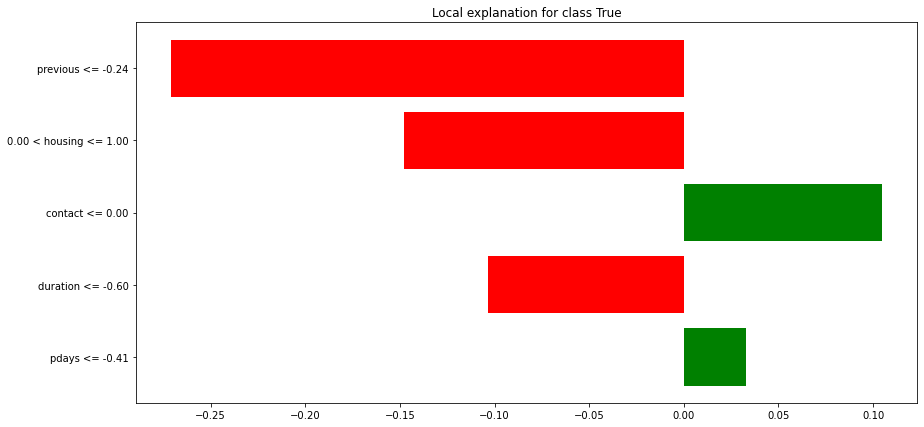

In [45]:
i = 106
exp = explainer.explain_instance(train[i], predict_fn)
pprint.pprint(exp.as_list())
fig = exp.as_pyplot_figure()

## 7) Train and Predict with Cloud AI Platform

We just saw how to train and predict our models locally. However, when we want more compute power or want to put our model in production serving 1000s of requests, we can use [Cloud AI Platform](https://cloud.google.com/ml-engine/docs/scikit/) to perform these tasks.

Let us define some environment variables that AI Platform uses. Do not forget to replace all the variables in square brackets (along with the square brackets) with your credentials.

In [53]:
%env GCS_BUCKET=gs://ai-platform-trail
%env REGION=us-central1
%env LOCAL_DIRECTORY=./trainer/data
%env TRAINER_PACKAGE_PATH=./trainer

env: GCS_BUCKET=gs://ai-platform-trail
env: REGION=us-central1
env: LOCAL_DIRECTORY=./trainer/data
env: TRAINER_PACKAGE_PATH=./trainer


AI Platform needs a Python package with our code to train models. We need to create a directory and move our code there. We also need to create an `__init__.py` file, this is a unique feature of python. You can read the [docs](https://docs.python.org/3/tutorial/modules.html#packages) to understand more about this file.

In [47]:
%%bash
mkdir trainer
touch trainer/__init__.py

In order for Cloud AI Platform to access the training data we need to upload a trainging file into Google Cloud Storage (GCS). We use our `strat_train_set` dataframe and convert it into a csv file which we upload to GCS. 

In [54]:
strat_train_set.to_csv('train.csv', index=None)
!gsutil cp train.csv $GCS_BUCKET

Copying file://train.csv [Content-Type=text/csv]...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


This next cell might seem very long,  however, most of the code is identical to earlier sections. We are simply combining the code we created previously into one file.

Before running this, cell substitute `<BUCKET_NAME>` with your GCS bucket name. Do not include the `'gs://'` prefix.


In [79]:
%%writefile trainer/task.py

import datetime
import os
import pandas as pd
import numpy as np
import subprocess

from google.cloud import storage

from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# TODO: REPLACE '<BUCKET_NAME>' with your GCS bucket name
BUCKET_NAME = 'ai-platform-trail'

# Bucket holding the training data
bucket = storage.Client().bucket(BUCKET_NAME)

# Path to the data inside the  bucket
blob = bucket.blob('train.csv')
# Download the data
blob.download_to_filename('train.csv')
# [END download-data]

# [START scikit-learn code]
# Load the training dataset
with open('./train.csv', 'r') as train_data:
    df = pd.read_csv(train_data)

def return_features_and_label(df_tmp):
    # Get all the columns except the one named "y"
    X = df_tmp.drop("y", axis=1)
    Y = df_tmp["y"].copy()
    # Convert label to an integer
    Y = LabelEncoder().fit_transform(Y)
    return X, Y

def data_pipeline(df_tmp):
    num_cols = df_tmp._get_numeric_data().columns
    cat_cols = list(set(df_tmp.columns) - set(num_cols))
    # Normalize Numeric Data
    df_tmp[num_cols] = StandardScaler().fit_transform(df_tmp[num_cols])
    # Convert categorical variables to integers
    df_tmp[cat_cols] = df_tmp[cat_cols].apply(LabelEncoder().fit_transform)
    return df_tmp

def create_classifiers():
    log_params = [{'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}]

    knn_params = [{'n_neighbors': [3, 4, 5]}]

    svc_params = [{'kernel': ['linear', 'rbf'], 'probability': [True]}]

    tree_params = [{'criterion': ['gini', 'entropy']}]

    forest_params = {'n_estimators': [1, 5, 10]}

    mlp_params = {'activation': [
                    'identity', 'logistic', 'tanh', 'relu'
                  ]}

    ada_params = {'n_estimators': [1, 5, 10]}

    classifiers = [
        ['LogisticRegression', LogisticRegression(random_state=42),
         log_params],
        ['KNeighborsClassifier', KNeighborsClassifier(), knn_params],
        ['SVC', SVC(random_state=42), svc_params],
        ['DecisionTreeClassifier',
         DecisionTreeClassifier(random_state=42), tree_params],
        ['RandomForestClassifier',
         RandomForestClassifier(random_state=42), forest_params],
        ['MLPClassifier', MLPClassifier(random_state=42), mlp_params],
        ['AdaBoostClassifier', AdaBoostClassifier(random_state=42),
         ada_params],
        ]

    return classifiers


def grid_search(model, parameters, name, X, y):
    clf = GridSearchCV(model, parameters, cv=3, refit = 'f1',
                       scoring='f1', verbose=0, n_jobs=4)
    clf.fit(X, y)
    best_estimator = clf.best_estimator_
  
    return [name, clf.best_score_, best_estimator]


def best_configuration(classifiers, training_values, testing_values):
    clfs_best_config = []
    best_clf = None
    best_score = 0

    for (name, model, parameters) in classifiers:
        clfs_best_config.append(grid_search(model, parameters, name,
                                training_values, testing_values))
    
    for name, quality, clf in clfs_best_config:
        if quality > best_score:
            best_score = quality
            best_clf = clf
    
    return best_clf


train_features, train_label = return_features_and_label(df)
train_features_prepared = data_pipeline(train_features)

predictors = train_features_prepared.columns
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train_features_prepared[predictors], train_label)

train_prepared_columns = [col for (selected, col) in zip(selector.get_support(), predictors) if selected == True]
train_features_prepared = train_features_prepared[train_prepared_columns]


x = train_features_prepared.values
y = train_label
classifiers = create_classifiers()
clf = best_configuration(classifiers, x[:100], y[:100])
# [END scikit-learn]


# [START export-to-gcs]
# Export the model to a file
model = 'model.joblib'
joblib.dump(clf, model)

# Upload the model to GCS
bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob('{}/{}'.format(
    datetime.datetime.now().strftime('model_%Y%m%d_%H%M%S'),
    model))
blob.upload_from_filename(model)
# [END export-to-gcs]

Overwriting trainer/task.py


To actully run the `train.py` file we need some parameters so that AI Platform knows how to set up the environment to run sucessfully.

In [62]:
%%bash

JOBNAME=banking_$(date -u +%y%m%d_%H%M%S)
echo $GCS_BUCKET/$JOBNAME/output

gs://ai-platform-trail/banking_210405_212306/output


In [63]:
%%bash 

JOBNAME=banking_$(date -u +%y%m%d_%H%M%S)

echo $JOBNAME 

gcloud ai-platform jobs submit training model_training_$JOBNAME \
        --job-dir $GCS_BUCKET/$JOBNAME/output \
        --package-path trainer \
        --module-name trainer.task \
        --region $REGION \
        --runtime-version=1.15 \
        --python-version=3.5 \
        --scale-tier BASIC

banking_210405_212306
jobId: model_training_banking_210405_212306
state: QUEUED


Job [model_training_banking_210405_212306] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe model_training_banking_210405_212306

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs model_training_banking_210405_212306


The above cell submits a job to AI Platform which you can view by going to the Google Cloud Console's sidebar and select `AI Platform > Jobs` or search `AI Platform` in the search bar. ONLY run the cells below after your job has completed sucessfully. (It should take approximately 8 minutes to run).





---



Now that we have trained our model and it is saved in GCS we need to perform prediction. There are two options available to use for prediction:

1.   Command Line
2.   Python



In [101]:
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]
test = test_prepared.values

Next, find the model directory in your GCS bucket that contains the model created in the previous steps.

In [95]:
!gsutil ls $GCS_BUCKET

gs://ai-platform-trail/train.csv
gs://ai-platform-trail/trained_ames_model.dat
gs://ai-platform-trail/ai-platform-trail/
gs://ai-platform-trail/babyweight_tft/
gs://ai-platform-trail/banking_210405_205918/
gs://ai-platform-trail/banking_210405_210328/
gs://ai-platform-trail/banking_210405_211729/
gs://ai-platform-trail/banking_210405_212306/
gs://ai-platform-trail/bike-sharing/
gs://ai-platform-trail/churn_prediction_output/
gs://ai-platform-trail/data_flow_output_dir-20210401_201103/
gs://ai-platform-trail/data_flow_output_dir-20210401_203323/
gs://ai-platform-trail/model/
gs://ai-platform-trail/model_20210405_212353/
gs://ai-platform-trail/output_data/
gs://ai-platform-trail/titanic/


Just like training in AI Platform, we set some environment variables when we run our command line commands. Note that `<GCS_BUCKET>` is your the name of your GCS bucket set earlier. The `MODEL_DIRECTORY` will be inside the GCS bucket and of the form `model_YYYYMMDD_HHMMSS` (e.g. `model_190114_134228`).

In [143]:
%env VERSION_NAME=v3
%env MODEL_NAME=cmle_model
%env JSON_INSTANCE=input.json
%env MODEL_DIR=gs://ai-platform-trail/model_20210405_212353
%env FRAMEWORK=SCIKIT_LEARN

env: VERSION_NAME=v3
env: MODEL_NAME=cmle_model
env: JSON_INSTANCE=input.json
env: MODEL_DIR=gs://ai-platform-trail/model_20210405_212353
env: FRAMEWORK=SCIKIT_LEARN


Create a model resource for your model versions as well as the version.

In [136]:
! gcloud ai-platform models create $MODEL_NAME --region=us-central1

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/healthy-earth-309119/models/cmle_model].


In [144]:
! gcloud ai-platform versions create $VERSION_NAME \
        --model $MODEL_NAME --origin $MODEL_DIR \
        --runtime-version 1.14 --framework $FRAMEWORK \
        --python-version 3.5

Using endpoint [https://us-central1-ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    


For prediction, we will upload a file with one line in our GCS bucket.

In [161]:
import json
with open('input.json', 'w') as outfile:
    [outfile.write("{}\n".format(l.to_json(orient='values'))) for _,l in test_prepared.head().iterrows()]

In [162]:
!gsutil cp input.json $GCS_BUCKET

Copying file://input.json [Content-Type=application/json]...
/ [1 files][  347.0 B/  347.0 B]                                                
Operation completed over 1 objects/347.0 B.                                      


We are now ready to submit our file to get a preditcion.

In [163]:
! gcloud ai-platform predict --model $MODEL_NAME \
        --version $VERSION_NAME \
        --json-instances $JSON_INSTANCE

Using endpoint [https://us-central1-ml.googleapis.com/]
[0, 0, 0, 0, 1]


We can also use python to perform predictions. See the cell below for a simple way to get predictions using python.

In [181]:
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions

def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        region (str): regional endpoint to use; set to None for ml.googleapis.com
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)
    service = googleapiclient.discovery.build(
        'ml', 'v1', client_options=client_options)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [182]:
predict_json(PROJECT_ID, 'us-central1', MODEL_NAME, [list(l) for l in test_prepared.head().values], VERSION_NAME)

[0, 0, 0, 0, 1]

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License